# Рекомендательные системы. 
## Двухуровневые модели рекомендаций

## Домашнее задание

**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

### Определение функций и классов

In [2]:
# функция показывающая сколько пользователей и товаров в передатнном датасете
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

# функция добавляющая рекомендации в результирующий датасет для оценки моделей
# recommend_models - список моделей для выдачи рекомендаций и последующей оценке их работы
def myEvalRecall(df_result, target_col_name, recommend_models, n_predict = 50, topk_recall = 50):
    for model in recommend_models:
        result_col_name = model
        df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_models[model](x, N=n_predict))
    return sorted(calc_recall(df_result, topk_recall), key=lambda x: x[1],reverse=True)

# функция добавляющая рекомендации в результирующий датасет для оценки моделей
def evalRecall(df_result, target_col_name, recommend_model, n_predict = 50, topk_recall = 50):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=n_predict))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=topk_recall), axis=1).mean()

# df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=n_predict), axis=1).mean()

# функция расчета метрики RECALL@K
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

# функция расчета метрики  PRECISION@K     
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Загрузка и подготовка данных

In [3]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

In [4]:
# объявим константы для дальнейшего использования
ITEM_COL = 'item_id'
USER_COL = 'user_id'
ACTUAL_COL = 'actual'

In [5]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

In [6]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

### Разбиваем данные на train, eval, test

In [8]:
# берем данные для тренировки matching модели - первый датасет 
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели - второй датасет (6 недель)
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели - второй датасет (6 недель)
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели - третий датасет (3 недели)
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

### Фильтрация данных

In [9]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

/Users/eugene/Документы/Education/AI/Рекомендательные системы/webinar_6/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


In [10]:
# ищем общих пользователей
# в итоге в каждом датасете пользователи одинаковые
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


## Init/train recommender

In [11]:
# используем наш класс и создадим экземпляр класса на базе первого датасета для отбора кандидатов
recommender = MainRecommender(data_train_matcher)

In [13]:
# количество рекомендуемых кандидатов
N_PREDICT = 50
# количество элементов для оценки в метрике recall
TOPK_RECALL = 50

In [14]:
# создадим базовую таблицу для последующей оценки моделей по рекомендованным кандидатам
# для этого используем валидационный датасет (второй, 6 недель)
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [15]:

candidad_models = {'own_rec': recommender.get_own_recommendations, 
                   'sim_item_rec': recommender.get_similar_items_recommendation, 
                   'als_rec': recommender.get_als_recommendations}

myEvalRecall(result_eval_matcher, USER_COL, candidad_models, n_predict = N_PREDICT, topk_recall = TOPK_RECALL)

[('own_rec', 0.06525657038145175),
 ('als_rec', 0.04830336847765984),
 ('sim_item_rec', 0.03195906847357955)]

**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

**Будем использовать модель own_recommender. Попробуем подобрать оптимальный размер вадлидационного датасета**

In [16]:
# попробуем разные варианты размера валидационного датасета 
val_matcher_weeks_list = [2, 3, 4, 5, 6, 7, 8, 9]
# размер валидационного датасета для ранжирования оставим без изменений
VAL_RANKER_WEEKS = 3
topRecall_k_list = []

for VAL_MATCHER_WEEKS in val_matcher_weeks_list:
    # берем данные для тренировки matching модели
    data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

    # берем данные для валидации matching модели
    data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]
    
    # фильтруем данные
    data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)
    
    # приводим к общим пользователям
    common_users = data_train_matcher.user_id.values

    data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
    
    # создаем модель
    recommender = MainRecommender(data_train_matcher)
    
    # создаем образец для сравнения
    result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
    result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
    # собираем метрику top@k_recall для каждого размера датасета и модели - Own
    topRecall_k_list.append(evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations))

/Users/eugene/Документы/Education/AI/Рекомендательные системы/webinar_6/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


/Users/eugene/Документы/Education/AI/Рекомендательные системы/webinar_6/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


/Users/eugene/Документы/Education/AI/Рекомендательные системы/webinar_6/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


/Users/eugene/Документы/Education/AI/Рекомендательные системы/webinar_6/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


/Users/eugene/Документы/Education/AI/Рекомендательные системы/webinar_6/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


/Users/eugene/Документы/Education/AI/Рекомендательные системы/webinar_6/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


/Users/eugene/Документы/Education/AI/Рекомендательные системы/webinar_6/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


/Users/eugene/Документы/Education/AI/Рекомендательные системы/webinar_6/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


In [68]:
topRecall_k_list

[0.0726715895267428,
 0.07233396357826527,
 0.06963128546812805,
 0.06601516222333519,
 0.06525657038145175,
 0.06355481695773037,
 0.060789335243799654,
 0.05975202694917673]

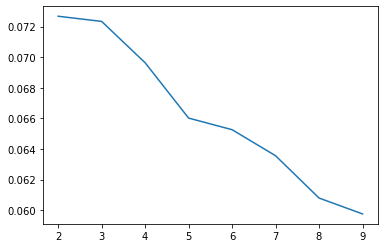

In [69]:
plt.plot(val_matcher_weeks_list, topRecall_k_list)
plt.show()

**Результат - чем меньше валидационный датасет, тем выше метрика**

**Построим зависимость метрики recall@k от  k**

In [17]:
VAL_MATCHER_WEEKS = 2
VAL_RANKER_WEEKS = 3

# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                  (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]

# фильтруем данные
data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

# приводим к общим пользователям
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]

# создаем модель
recommender = MainRecommender(data_train_matcher)

# создаем образец для сравнения
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]

n_predict_list = [20, 50, 100, 200, 500]
topRecall_k_list = []
for k in n_predict_list:
    topRecall_k_list.append(evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations, n_predict=k, topk_recall=k))

/Users/eugene/Документы/Education/AI/Рекомендательные системы/webinar_6/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


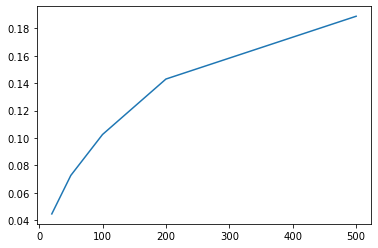

In [18]:
plt.plot(n_predict_list, topRecall_k_list)
plt.show()

In [19]:
topRecall_k_list

[0.04458836997495892,
 0.0726715895267428,
 0.10252046737621084,
 0.142973687297826,
 0.18878184251639613]

**Результат - чем больше количество кандидатов, тем выше метрика**

**C) Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?**

k = 500 дало лучшие результаты. Чем больше кандидатов, тем дольше будет работать модель второго уровня. Оставлю пока 500, в целом это небольшой датасет для последующего ранжирования.


**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

## 2 й уровень. Ранжирование

### Фиксируем метрику после первого уровня на data_val_matcher

Размеры датасетов:
data_val_matcher = data_train_ranker - 2 недели
data_val_ranker - 3 недели

In [20]:
TOPK_PRECISION = 5
N_PREDICT = 500

In [21]:
precision_1st = sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

In [22]:
print(f'Precision после первого уровня на data_val_matcher: {precision_1st[0][1]}')

Precision после первого уровня на data_val_matcher: 0.11060869565217354


### Подготовка данных для ранжирования из data_train_ranker:


In [23]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [24]:
# разворачиваем список кандидатов в DataFrame
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)


In [25]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


In [29]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (1075500, 2) Users: 2151 Items: 4647


In [30]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

# присоединяем к рекомендованным кандидатам имеющиеся покупки
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

# присвоим присоединенным кандидатам значение таргета (раз мы не знаем куплен был товар или нет, предположим - нет ) - 0
df_ranker_train['target'].fillna(0, inplace= True)


In [31]:
# получившиееся распределение целевой переменной
df_ranker_train.target.value_counts()

0.0    977413
1.0     35619
Name: target, dtype: int64

In [32]:
# присоединим к user - item таблице информацию по юзерам и информацию по товарам
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [33]:
# отделим целевую переменную из получившегося датасета
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

### Обучение модели ранжирования

In [34]:
# используем lightGBM классификатор
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

df_ranker_predict = df_ranker_train.copy()

df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

/Users/eugene/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/eugene/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [35]:
df_ranker_predict.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,proba_item_purchase
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.059840
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.020894


### Evaluation on test dataset

In [36]:
# создадим образец для оценки метрик на валидационном датасете для ранжирования (data_vak_ranker - 3 недели)
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [37]:
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
# посчитаем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.15225490196078306)]

**Метрика precision@5 на 500 рекомендованных кандидатах без ранжирования = 0,1523**

### Ranking

In [38]:
# функция возвращает список из отранжированных топ - 5 товаров для каждого пользователя
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [39]:
# добавим топ - 5 отранжированных товаров для каждого пользователя в таблицу для оценки метрик
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [40]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.15853785900783107)
('own_rec', 0.15225490196078306)


/Users/eugene/Документы/Education/AI/Рекомендательные системы/webinar_6/metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


In [44]:
est_precision = sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)
print(f'После ранжирования метрика precision@5 выросла на: {(est_precision[0][1]/ est_precision[1][1]-1)*100}%')

После ранжирования метрика precision@5 выросла на: 4.126604113321974%


### Adding features

**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее кол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [45]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [53]:
data_train_ranker.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


#### Добавим средний чек на пользователя

In [128]:
# посчитаем средний чек на пользователя на тренировочном датасете для отбора кандидатов
# по хорошему нужно было бы объединить датасеты для отобра кандидатов
(data_train_ranker.groupby(USER_COL).agg('sales_value').sum()/data_train_ranker.groupby(USER_COL).agg('quantity').sum()).rename('average_check')

user_id
1       2.309324
2       2.265357
4       3.141842
6       2.333333
7       1.617672
          ...   
2496    2.077006
2497    0.114116
2498    2.671594
2499    2.619787
2500    0.009930
Name: average_check, Length: 2151, dtype: float64

In [47]:
# добавим средний чек пользователя к тренировочному датасету для ранжирования
df_ranker_train = df_ranker_train.merge((data_train_ranker.groupby(USER_COL).agg('sales_value').sum()/data_train_ranker.groupby(USER_COL).agg('quantity').sum()).rename('average_check'), how='left', on=USER_COL)

In [48]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_check
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.035173
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.035173


#### Добавим частоту фактов покупки в месяц

In [126]:
# посчитаем частоту фактов покупок пользователя в месяц
(data_train_ranker.groupby(by=USER_COL).agg(USER_COL).count()/(data_train_ranker.week_no//4).nunique()).rename('user_freq_per_month')

user_id
1       66.5
2       38.0
4       12.0
6       51.0
7       45.0
        ... 
2496    71.0
2497    80.0
2498    29.5
2499    39.0
2500    48.0
Name: user_freq_per_month, Length: 2151, dtype: float64

In [54]:
# добавим частоту фактов покупок пользователя в месяц в тренировочный датасет для ранжирования
df_ranker_train = df_ranker_train.merge((data_train_ranker.groupby(by=USER_COL).agg(USER_COL).count()/(data_train_ranker.week_no//4).nunique()).rename('user_freq_per_month'), how='left', on= USER_COL)

In [55]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_check,user_freq_per_month
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.035173,102.0
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.035173,102.0


#### Добавим общую сумму продажи по каждому товару

In [70]:
# общая сумма продажи товара
data_train_ranker.groupby(by=ITEM_COL).agg('sales_value').sum().rename('total_item_sales_value')

item_id
28116        0.33
28117        0.34
28143        0.33
28186        0.79
28304        0.53
            ...  
17381856     0.00
17382205     7.99
17383227     4.49
17827644     2.50
17829232    11.98
Name: total_item_sales_value, Length: 27644, dtype: float64

In [71]:
# добавим общую сумму продажи товара в тренировочный датасет для ранжирования
df_ranker_train = df_ranker_train.merge(data_train_ranker.groupby(by=ITEM_COL).agg('sales_value').sum().rename('total_item_sales_value'), how='left', on=ITEM_COL)

In [72]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_check,user_freq_per_month,total_item_sales_value
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.035173,102.0,19.95
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.035173,102.0,10.99


#### Добавим общее количество продаж каждого товара

In [81]:

data_train_ranker.groupby(by=ITEM_COL).agg('quantity').sum().rename('total_quantity_value')

item_id
28116       1
28117       1
28143       1
28186       1
28304       1
           ..
17381856    0
17382205    1
17383227    1
17827644    1
17829232    2
Name: total_quantity_value, Length: 27644, dtype: int64

In [82]:
# добавим общее количество продаж каждого товара в тренировочный датасет для ранжирования
df_ranker_train = df_ranker_train.merge(data_train_ranker.groupby(by=ITEM_COL).agg('quantity').sum().rename('total_quantity_value'), how='left', on=ITEM_COL)

In [83]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_check,user_freq_per_month,total_item_sales_value,total_quantity_value
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.035173,102.0,19.95,5.0
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.035173,102.0,10.99,1.0


#### Добавим количество продаж каждого товара в неделю

In [91]:
data_train_ranker.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_week')/data_train_ranker.week_no.nunique()

item_id
28116       0.166667
28117       0.166667
28143       0.166667
28186       0.166667
28304       0.166667
              ...   
17381856    0.000000
17382205    0.166667
17383227    0.166667
17827644    0.166667
17829232    0.333333
Name: item_quantity_per_week, Length: 27644, dtype: float64

In [92]:
# добавим количество продаж каждого товара в неделю в тренировочный датасет для ранжирования
df_ranker_train = df_ranker_train.merge( data_train_ranker.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_week')/data_train_ranker.week_no.nunique(),how='left', on=ITEM_COL)

In [93]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_check,user_freq_per_month,total_item_sales_value,total_quantity_value,item_quantity_per_week
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,0.035173,102.0,19.95,5.0,0.833333
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,0.035173,102.0,10.99,1.0,0.166667


#### Добавим количество товаров каждого производителя для каждого пользователя (user-item features)

In [135]:
# adding user-item features
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [107]:
# add quantity items per user per brand
df_ranker_train.groupby(by=['user_id', 'manufacturer']).agg('item_id').count().rename('item_quantity_per_user_per_manufacturer')

user_id  manufacturer
1        2               31
         5                1
         61               1
         69              76
         93               2
                         ..
2500     5937             1
         6046             1
         6082             1
         6216             1
         6331             1
Name: item_quantity_per_user_per_manufacturer, Length: 413832, dtype: int64

In [109]:
# добавим количество товара каждого производителя по каждому пользователю в тренировочный датасет для ранжирования
df_ranker_train = df_ranker_train.merge(df_ranker_train.groupby(by=['user_id', 'manufacturer']).agg('item_id').count().rename('item_quantity_per_user_per_manufacturer') , how='left', on=['user_id', 'manufacturer'])

In [110]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_check,user_freq_per_month,total_item_sales_value,total_quantity_value,item_quantity_per_week,item_quantity_per_user_per_manufacturer
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,Unknown,Unknown,1,None/Unknown,0.035173,102.0,19.95,5.0,0.833333,95
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,Unknown,Unknown,1,None/Unknown,0.035173,102.0,10.99,1.0,0.166667,1


#### Добавим количество товаров в каждой категории которые покупал каждый пользователь

In [134]:
# add quantity items per user per department
df_ranker_train.groupby(by=['user_id', 'department']).agg('item_id').count().rename('item_department_per_user_per_department')

user_id  department   
1        DELI              39
         DRUG GM           19
         GROCERY          236
         MEAT              58
         MEAT-PCKGD        47
                         ... 
2500     NUTRITION          3
         PASTRY             2
         PRODUCE           64
         SEAFOOD            3
         SEAFOOD-PCKGD      2
Name: item_department_per_user_per_department, Length: 21910, dtype: int64

In [135]:
df_ranker_train = df_ranker_train.merge( df_ranker_train.groupby(by=['user_id', 'department']).agg('item_id').count().rename('item_department_per_user_per_department'),how='left', on=['user_id', 'department'])

In [136]:
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,household_size_desc,kid_category_desc,average_check,user_freq_per_month,total_item_sales_value,total_quantity_value,item_quantity_per_week,item_quantity_per_user_per_manufacturer,item_department_per_user_per_brand,item_department_per_user_per_department
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,1,None/Unknown,0.035173,102.0,19.95,5.0,0.833333,95,30,30
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,1,None/Unknown,0.035173,102.0,10.99,1.0,0.166667,1,209,209


In [137]:
df_ranker_train.columns.tolist()

['user_id',
 'item_id',
 'target',
 'manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'average_check',
 'user_freq_per_month',
 'total_item_sales_value',
 'total_quantity_value',
 'item_quantity_per_week',
 'item_quantity_per_user_per_manufacturer',
 'item_department_per_user_per_brand',
 'item_department_per_user_per_department']

In [138]:
train_columns = [
    'user_id',
    'item_id',
    'target',
    'manufacturer',
    'department',
    'brand',
    'commodity_desc',
    'sub_commodity_desc',
    'curr_size_of_product',
    'age_desc',
    'marital_status_code',
    'income_desc',
    'homeowner_desc',
    'hh_comp_desc',
    'household_size_desc',
    'kid_category_desc',
    'average_check',
    #'user_freq_per_month',
    'total_item_sales_value',
    'total_quantity_value',
    #'item_quantity_per_week',
    #'item_quantity_per_user_per_manufacturer',
    #'item_department_per_user_per_department'
]

In [139]:
df_train = df_ranker_train[train_columns]

In [140]:
X_train = df_train.drop('target', axis=1)
y_train = df_train[['target']]

cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')


In [141]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

df_ranker_predict = df_ranker_train.copy()

df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

/Users/eugene/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/eugene/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [142]:
result_eval_ranker['reranked_own_rec_exclude_feature_item_quantity_per_user_per_department'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [143]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

/Users/eugene/Документы/Education/AI/Рекомендательные системы/webinar_6/metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


('reranked_own_rec_add_feature_total_item_quantity', 0.19446475195822183)
('reranked_own_rec_add_feature_item_quantity_per_week', 0.19446475195822183)
('reranked_own_rec_exclude_feature_item_quantity_per_week', 0.19446475195822183)
('reranked_own_rec_exclude_feature_item_quantity_per_user_per_manufacturer', 0.19446475195822183)
('reranked_own_rec_exclude_feature_item_quantity_per_user_per_department', 0.19446475195822183)
('reranked_own_rec_add_feature_item_quantity_per_user_per_department', 0.19436031331592443)
('reranked_own_rec_add_feature_total_item_sales_value', 0.18851174934725606)
('reranked_own_rec_add_features_average_check', 0.17503916449085966)
('reranked_own_rec_exclude_feature_user_freq_per_month', 0.17503916449085966)
('reranked_own_rec_add_features_user_freq_per_month', 0.1706527415143583)
('reranked_own_rec', 0.15853785900783107)
('own_rec', 0.15225490196078306)


In [144]:
est_precision = sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)
print(f'Метрика precision@5 увеличена на: {(est_precision[0][1]/est_precision[-1][1] - 1)*100}%')

Метрика precision@5 увеличена на: 27.723146810938772%


**Результат - при добавлении новых признаков, итоговую метрику удалось увеличить на 27%. Не все добавляемые признаки приводили к увеличению метрики. Те что уменьшали, были удалены из обучения и прогнозирования**